In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import pandas as pd

Global seed set to 0


In [2]:
adata = sc.read('../../DeepVeloData/deepvelo_data/h5ad_files/Hindbrain_GABA_Glio.h5ad')
adata.X = adata.layers['spliced'].copy()

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class _LabelEncoder(LabelEncoder):
    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

In [4]:
labelencoder = _LabelEncoder()
labelencoder.fit(np.array(adata.obs.Timepoint.cat.categories))
adata.obs['exp_time'] = labelencoder.transform(adata.obs.Timepoint).astype(float)
scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.anvi_clean_recipe(adata, log=True, batch_key = 'Timepoint', celltype_key='Celltype')

Filtered out 45980 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.AnnotVAE(observed=2000, latent_dim=20, zr_dim=1,
                            h_dim=2, 
                            celltypes=len(adata.obs['Celltype'].unique()),
                            exp_time=True, time_reg=True, time_reg_weight=3, time_reg_decay=5)

In [6]:
epochs, val_ae, val_traj = ltv.train_anvi(model, adata, batch_size = 1100,
                                     epochs=25, name='hindbrain_gaba_glial', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
996 velocity genes used
epoch 0, full loss 236.376, val loss 141.630, ae MSE 1.869, traj MSE 1.231, reg loss -2.408
epoch 1, full loss 119.448, val loss 97.386, ae MSE 1.370, traj MSE 0.890, reg loss -2.845
epoch 2, full loss 98.614, val loss 73.779, ae MSE 1.137, traj MSE 0.748, reg loss -2.920
epoch 3, full loss 105.772, val loss 51.498, ae MSE 1.070, traj MSE 0.699, reg loss -2.822
epoch 4, full loss 62.935, val loss 31.760, ae MSE 1.059, traj MSE 0.673, reg loss -2.038
epoch 5, full loss 30.834, val loss 11.751, ae MSE 0.964, traj MSE 0.671, reg loss -2.761
epoch 6, full loss 14.023, val loss -12.178, ae MSE 0.871, traj MSE 0.622, reg loss -2.160
epoch 7, full loss -15.707, val loss -34.889, ae MSE 0.834, traj MSE 0.605, reg loss -2.049
epoch 8, full loss -20.969, val loss -58.334, ae MSE 0.759, traj MSE 0.586, reg loss -1.985
epoch 9, full loss -42.801, val loss -81.821, ae MSE 0.739, traj MSE 0.579, reg loss -1.72

computing velocity graph (using 1/16 cores)


  0%|          | 0/13501 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


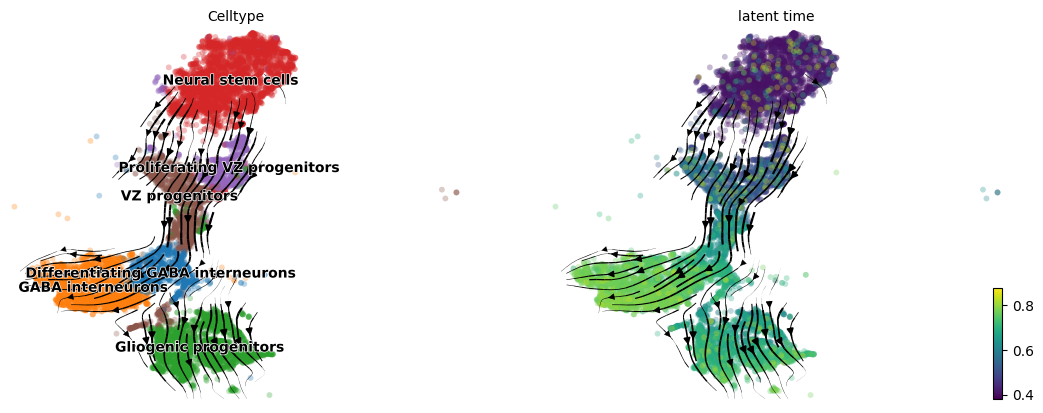

In [7]:
latent_adata = ltv.output_results(model, adata, embedding='tsne')
    
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['Celltype', 'latent_time'])

saving figure to file ../figures/hindbrain_gaba_model_tsne_lineages.png


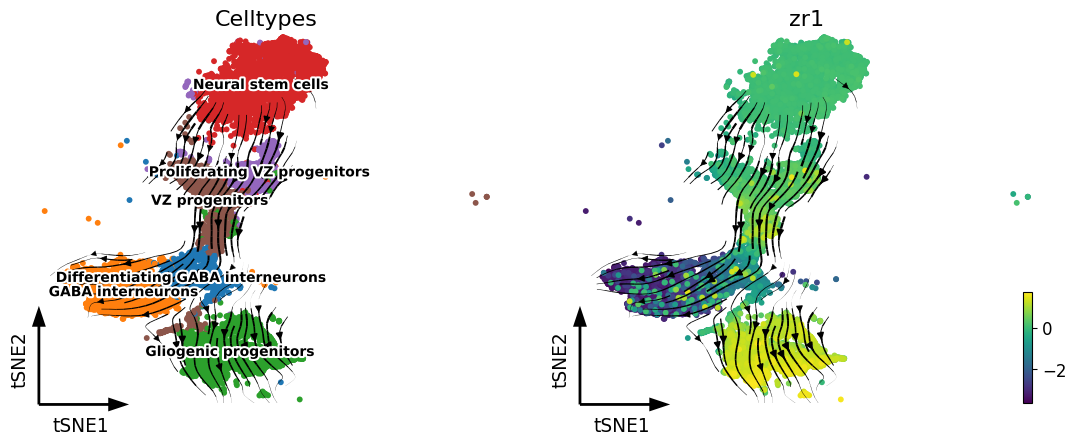

In [8]:
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['Celltype', 'zr1'], 
                                 title=['Celltypes', 'zr1'], alpha=1, 
                                 legend_fontsize=10, legend_fontoutline=3, fontsize=16, frameon='artist',
                                save='../figures/hindbrain_gaba_model_tsne_lineages.png')

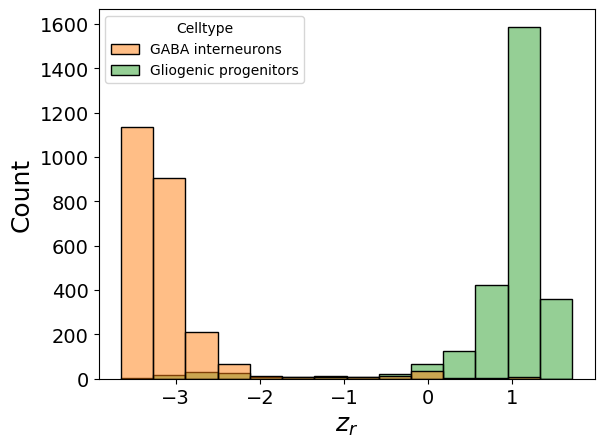

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
latent_adata.obs['zr'] = latent_adata.obsm['zr'][:,0]
plot = sns.histplot(data=latent_adata[latent_adata.obs.Celltype.isin(['Gliogenic progenitors', 'GABA interneurons'])].obs, x='zr',hue='Celltype',
               palette=list(latent_adata[latent_adata.obs.Celltype.isin(['Gliogenic progenitors', 'GABA interneurons'])].uns['Celltype_colors']))

plot.set_ylabel("Count",fontsize=18)
plot.set_xlabel(r"$z_r$",fontsize=18)
plot.tick_params(labelsize=14)
plt.savefig('../figures/hindbrain_gaba_zr.pdf', fontsize=18)
plt.show()

In [10]:
gaba_edges = [('Neural stem cells', 'progenitors'), ('Proliferating VZ progenitors', 'VZ progenitors'),
                         ('VZ progenitors', 'Gliogenic progenitors'), 
                          ('VZ progenitors', 'Differentiating GABA interneurons'),
                         ('Differentiating GABA interneurons', 'GABA interneurons')]

scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
gaba_pca = ltv.ev.cross_boundary_correctness(latent_adata,
            'Celltype', 'spliced_velocity_pca', gaba_edges, x_emb='X_pca', 
              majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:04) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


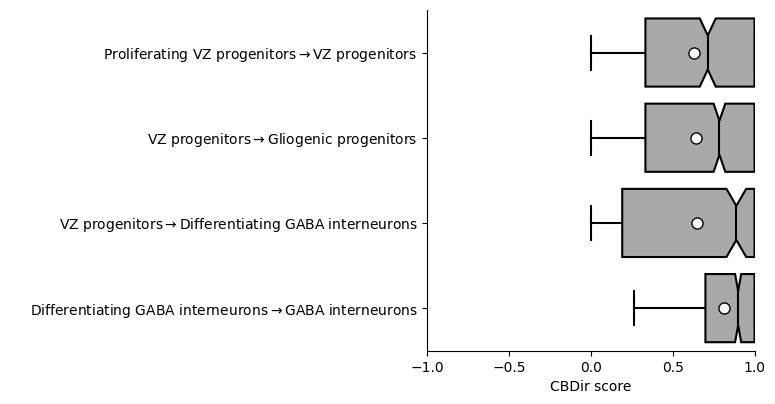

In [11]:
import matplotlib.pyplot as plt
ltv.pl.transition_scores(gaba_pca, raw=True)
plt.show()

In [13]:
# save fit
latent_adata.write('../benchmark/real_data/fits/hindbrain_gaba_latent_adata.h5ad')